In [82]:
# Imports

import numpy as np
import pandas as pd
import os, os.path
from itertools import *
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import math
import random
import scipy.stats
import sys
from joblib import Parallel, delayed
import multiprocessing
nproc = max(1, multiprocessing.cpu_count() - 1)
from scipy.sparse import csr_matrix
from random import choice
from sklearn.decomposition import TruncatedSVD
from scipy.sparse.linalg import svds
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import IncrementalPCA

# Warnings

import warnings
warnings.filterwarnings('ignore')

# Uncompress data

if not os.path.exists('data'):
    os.mkdir('data')

def have_data():
    return {'testTriplets.txt', 'txTripletsCounts.txt'}.issubset(set(os.listdir('data')))
if not have_data():
    ! cp Assignment3_Bitcoin/data.zip .
    ! unzip data.zip
    ! rm data.zip
    if not have_data():
        raise Exception('Error unpacking data')
        
# Extract data in df form and as a sparse matrix

dftrain = pd.read_csv('data/txTripletsCounts.txt',
                      header=None,
                      index_col=None,
                      sep=' ',
                      names=['sender','receiver','transaction'])

dftest = pd.read_csv('data/testTriplets.txt',
                     header=None,
                     index_col=None,
                     sep=' ',
                     names=['sender','receiver','transaction'])
dim = max(df[c].max() for df in (dftrain, dftest) for c in ['sender', 'receiver'])
dim += 1

# both the matrices here have m[i, j] return the number of transactions from i to j
# in training.
train_csr = csr_matrix((dftrain['transaction'],(dftrain['sender'],dftrain['receiver'])),
                       shape=(dim,dim),
                       dtype=float)
train_csc = train_csr.tocsc()

# As a NetworkX graph

import networkx as nx
import scipy
G = nx.from_scipy_sparse_matrix(train_csr, parallel_edges=False, create_using=nx.DiGraph())

In [2]:
# (Takes and Kosters 2013) http://www.mdpi.com/1999-4893/6/1/100/htm
# Sample a distribution (only need about 0.1) for these metrics for each vertex
# vertex eccentricity, vertex connectivity, closeness centrality
# betweeness centrality

# (TODO this should come in from B)
#get each of the three things working for one vertex, then take a distribution of the whole thing, then make
# a box and whisker plot of each of those three things on that distribution (the 10% size graph)

# vertex eccentricity
# print(nx.eccentricity(G, 10))
# says "NetworkXError: Graph not connected: infinite path length"

# vertex connectivity
from networkx.algorithms.connectivity import local_node_connectivity
# print( nx.local_node_connectivity(G, 1, 2))
# says "AttributeError: 'module' object has no attribute 'local_node_connectivity'"

# closeness centrality
print( nx.closeness_centrality(G, 1))

# betweeness centrality
# print( nx.betweenness_centrality(G))
# seems like it only does it for all nodes

0.40751281557351193


In [3]:
# sampling distribution

a = np.empty(int(len(G)/100000))
for i in a:
    a[i] = nx.closeness_centrality(G, choice(G.nodes()))
print(a)

[  3.30884254e-001   6.90023186e-310   6.90023198e-310   6.90023198e-310]


{'boxes': [<matplotlib.lines.Line2D at 0x7fca9405c710>],
 'caps': [<matplotlib.lines.Line2D at 0x7fca93feac10>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fca93ff8610>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fca93ff4cd0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fca9405ca90>,
  <matplotlib.lines.Line2D at 0x7fca9409c3d0>]}

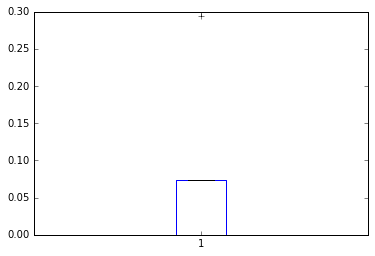

In [7]:
# box & whiskers
plt.boxplot(a)

In [89]:
# looking at some decompositions
# partially adapted from preceptors' code

target = csr_matrix(train_csr, shape=(dim,dim), dtype=float)
print(target.shape)
print(target.dtype)
print(train_csr.shape)
print(train_csr.dtype)

ipca = IncrementalPCA()

X = ipca.fit_transform(train_csr)
# memory error, idk what's happening here

(444075, 444075)
float64
(444075, 444075)
float64


TypeError: A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.

In [54]:
# can ignore this pretty much

# trying to create a test_csr, don't know exactly how to do it
dimtest = max(df[c].max() for df in dftest for c in ['sender', 'receiver'])

test_csr = csr_matrix((dftest['transaction'],(dftest['sender'],dftest['receiver'])),
                       shape=(dimtest,dimtest),
                       dtype=float)
print(test_csr.shape)

TypeError: string indices must be integers

Area under the ROC curve 0.672197888889


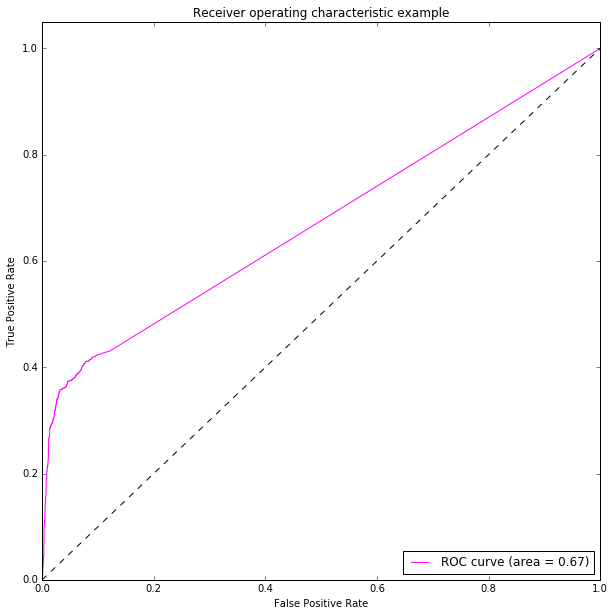

In [75]:
# trying NMF
from sklearn.decomposition import NMF
model = NMF(n_components=7, init='nndsvd', random_state=0)
W = model.fit_transform(train_csr)
H = model.components_
W[0,:].dot(H[:,1])
pred = [np.sum(W[row['sender'],:] * H[:,row['receiver']]) 
        for index,row in dftest.iterrows()]
label = dftest['transaction']
fpr, tpr, thresholds = roc_curve(label, pred)
roc_auc = auc(fpr, tpr)
print('Area under the ROC curve', roc_auc)
matplotlib.rcParams['figure.figsize'] = (10, 10)
plt.plot(fpr, tpr, color='magenta', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [90]:
# Factor Analysis
from sklearn.decomposition import FactorAnalysis
model = FactorAnalysis()
X = model.fit_transform(train_csr)
# doesn't work on sparse

TypeError: A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.

In [91]:
# Sparse PCA
from sklearn.decomposition import SparsePCA
model = SparsePCA()
X = model.fit_transform(train_csr)
# doesn't work with sparse data

TypeError: A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.

In [92]:
# Randomized PCA
from sklearn.decomposition import RandomizedPCA
model = RandomizedPCA(n_components=2)
X = model.fit_transform(train_csr)

TypeError: A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.

In [96]:
# Fast ICA
from sklearn.decomposition import FastICA
model = FastICA(n_components=2)
X = model.fit_transform(train_csr)
# same shit, needs dense data

TypeError: A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.

Truncated SVD, binary
Area under the ROC curve 0.701801888889


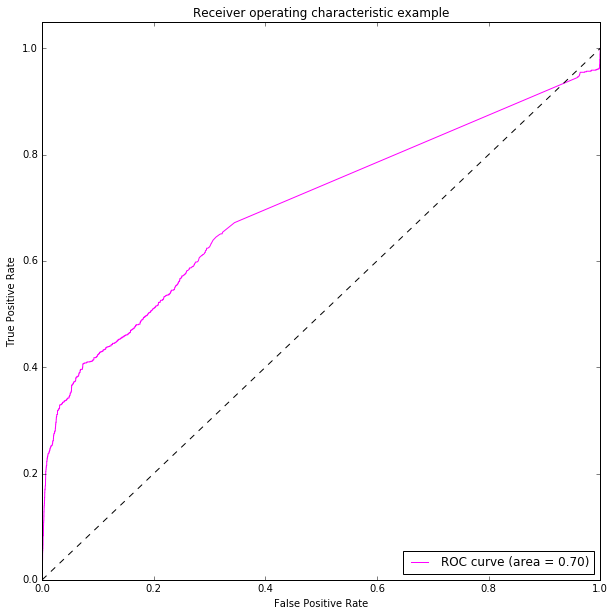

NMF, binary
Area under the ROC curve 0.725085555556


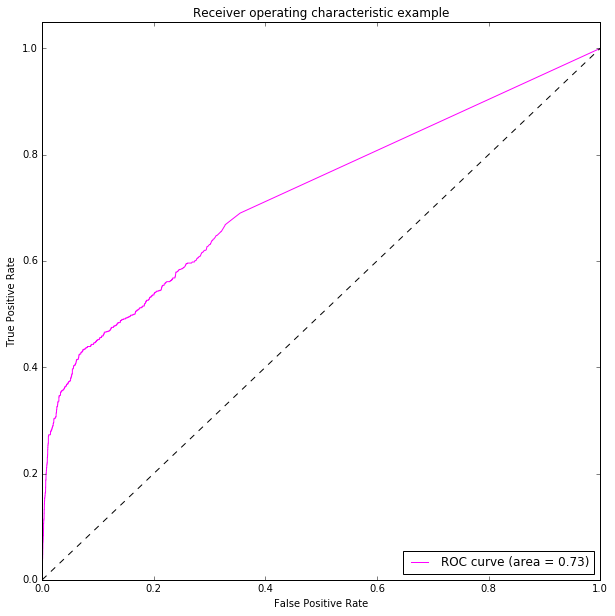

In [101]:
# trying some binary shit
bincsr = train_csr.sign()

# their thing
from sklearn.decomposition import TruncatedSVD
from scipy.sparse.linalg import svds
from sklearn.metrics import roc_curve, auc
u, s, vt = svds(bincsr, k=10, tol=1e-10, which = 'LM')
pred1 = [np.sum(u[row['sender'],:] * s * vt[:,row['receiver']]) 
        for index,row in dftest.iterrows()]
label = dftest['transaction']
fpr, tpr, thresholds = roc_curve(label, pred1)
roc_auc = auc(fpr, tpr)
print('Truncated SVD, binary')
print('Area under the ROC curve', roc_auc)
matplotlib.rcParams['figure.figsize'] = (10, 10)
plt.plot(fpr, tpr, color='magenta', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# my thing
from sklearn.decomposition import NMF
model = NMF(n_components=7, init='nndsvd', random_state=0)
W = model.fit_transform(bincsr)
H = model.components_
W[0,:].dot(H[:,1])
pred2 = [np.sum(W[row['sender'],:] * H[:,row['receiver']]) 
        for index,row in dftest.iterrows()]
label = dftest['transaction']
fpr, tpr, thresholds = roc_curve(label, pred2)
roc_auc = auc(fpr, tpr)
print('NMF, binary')
print('Area under the ROC curve', roc_auc)
matplotlib.rcParams['figure.figsize'] = (10, 10)
plt.plot(fpr, tpr, color='magenta', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

NMF, binary
Area under the ROC curve 0.709661722222


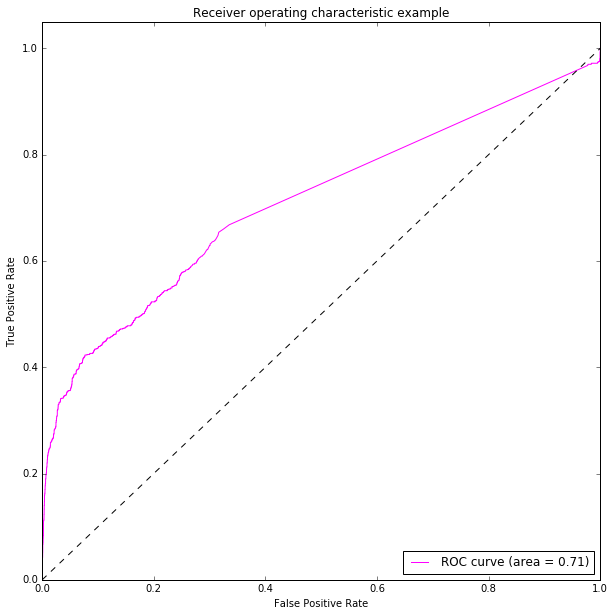

In [102]:
# Combining Truncated SVD with NMF somehow
# will use binary since those performed better

predAVG = (np.array(pred1) + np.array(pred2)) / 2
label = dftest['transaction']
fpr, tpr, thresholds = roc_curve(label, predAVG)
roc_auc = auc(fpr, tpr)
print('NMF, binary')
print('Area under the ROC curve', roc_auc)
matplotlib.rcParams['figure.figsize'] = (10, 10)
plt.plot(fpr, tpr, color='magenta', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Truncated SVD, binary
Area under the ROC curve 0.711162833333


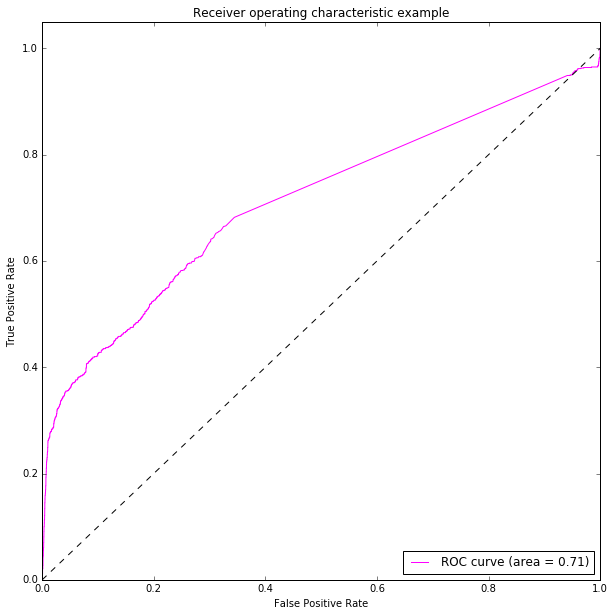

NMF, binary
Area under the ROC curve 0.718334055556


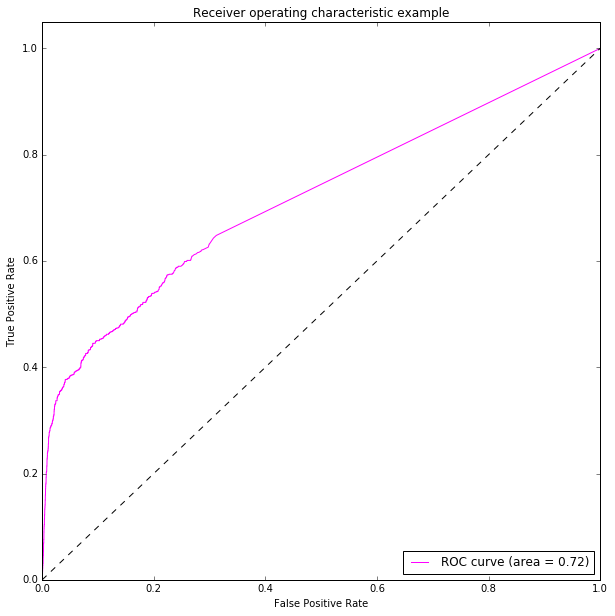

In [104]:
# trying log instead of binary
logcsr = train_csr.log1p()

# their thing
from sklearn.decomposition import TruncatedSVD
from scipy.sparse.linalg import svds
from sklearn.metrics import roc_curve, auc
u, s, vt = svds(logcsr, k=10, tol=1e-10, which = 'LM')
pred1 = [np.sum(u[row['sender'],:] * s * vt[:,row['receiver']]) 
        for index,row in dftest.iterrows()]
label = dftest['transaction']
fpr, tpr, thresholds = roc_curve(label, pred1)
roc_auc = auc(fpr, tpr)
print('Truncated SVD, binary')
print('Area under the ROC curve', roc_auc)
matplotlib.rcParams['figure.figsize'] = (10, 10)
plt.plot(fpr, tpr, color='magenta', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# my thing
from sklearn.decomposition import NMF
model = NMF(n_components=6, init='nndsvd', random_state=0)
W = model.fit_transform(logcsr)
H = model.components_
W[0,:].dot(H[:,1])
pred2 = [np.sum(W[row['sender'],:] * H[:,row['receiver']]) 
        for index,row in dftest.iterrows()]
label = dftest['transaction']
fpr, tpr, thresholds = roc_curve(label, pred2)
roc_auc = auc(fpr, tpr)
print('NMF, binary')
print('Area under the ROC curve', roc_auc)
matplotlib.rcParams['figure.figsize'] = (10, 10)
plt.plot(fpr, tpr, color='magenta', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

NMF, binary
Area under the ROC curve 0.659961888889


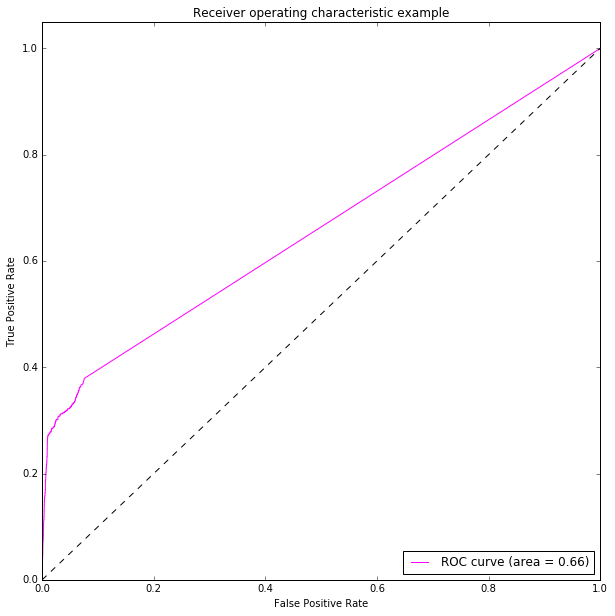

In [112]:
# Varying number of components to see what works best
# this is just binary NMF
# now looking at alpha (regularization) and l1_ratio
# didn't work too well
bincsr = train_csr.sign()
from sklearn.decomposition import NMF
model = NMF(n_components=6, init='nndsvd', random_state=0, alpha=1.0, l1_ratio=0.4)
W = model.fit_transform(bincsr)
H = model.components_
W[0,:].dot(H[:,1])
pred = [np.sum(W[row['sender'],:] * H[:,row['receiver']]) 
        for index,row in dftest.iterrows()]
label = dftest['transaction']
fpr, tpr, thresholds = roc_curve(label, pred)
roc_auc = auc(fpr, tpr)
print('NMF, binary')
print('Area under the ROC curve', roc_auc)
matplotlib.rcParams['figure.figsize'] = (10, 10)
plt.plot(fpr, tpr, color='magenta', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

NMF, binary
Area under the ROC curve 0.521292


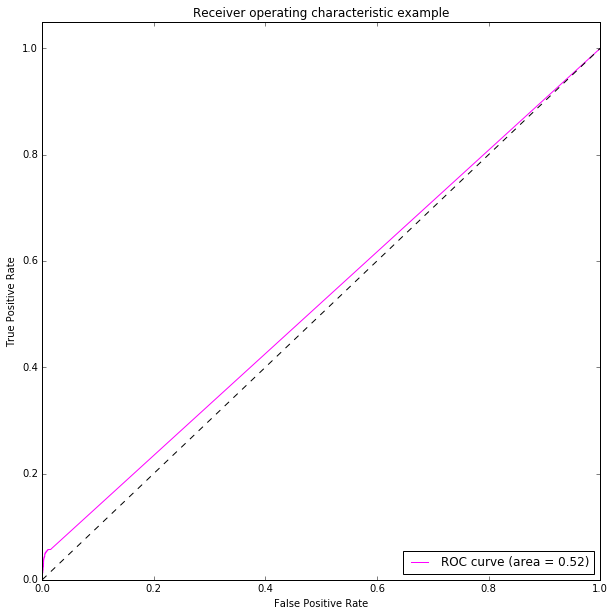

In [113]:
# Working with normalized matrix instead of binary
# http://stackoverflow.com/questions/12305021/efficient-way-to-normalize-a-scipy-sparse-matrix
# went down to 0.52, can ignore that I think
from sklearn.preprocessing import normalize
norm_csr = normalize(train_csr, norm='l1', axis=1)
model = NMF(n_components=4, init='nndsvd', random_state=0)
W = model.fit_transform(norm_csr)
H = model.components_
W[0,:].dot(H[:,1])
pred = [np.sum(W[row['sender'],:] * H[:,row['receiver']]) 
        for index,row in dftest.iterrows()]
label = dftest['transaction']
fpr, tpr, thresholds = roc_curve(label, pred)
roc_auc = auc(fpr, tpr)
print('NMF, binary')
print('Area under the ROC curve', roc_auc)
matplotlib.rcParams['figure.figsize'] = (10, 10)
plt.plot(fpr, tpr, color='magenta', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [119]:
# Clustering: will use Adamic-Adar as score

# first, turning into binary undirected graph
sym_csr = (train_csr + train_csr.transpose()).sign()
simple_G = nx.from_scipy_sparse_matrix(sym_csr)


In [120]:
# computing AA index for all pairs of nodes that have an edge
x = sorted(list(nx.adamic_adar_index(simple_G, simple_G.edges_iter())), key=lambda x: x[2])
print(x[0])

KeyboardInterrupt: 

In [137]:
# timing for first 10,000
import time
import itertools
import pickle
#with open('/tmp/simpleg.p', 'wb') as w: pickle.dump(simple_G, w)
def getaa(i):
    with open('/tmp/simpleg.p', 'rb') as r:
        sg = pickle.load(r)
    return list(nx.adamic_adar_index(sg, i))

def chunks(l, n):
    return [l[x:x+n] for x in range(0, len(l), n)]
preds = Parallel(n_jobs=5)(delayed(getaa)(i) for i in chunks(l, 5))
#                            in l)
#print(l)



In [138]:
preds

[[(0, 1, 0.4084221575116027),
  (0, 18, 0.712033115796598),
  (0, 51, 0.9665327840628499),
  (0, 37, 1.5878677186224617),
  (0, 81, 1.270053139709011)],
 [(0, 73, 0.7119960601478484),
  (0, 106, 1.2700350218702559),
  (0, 239244, 0.4170613930113015),
  (0, 13, 0.4084221575116027),
  (0, 438481, 0.10351952155128252)],
 [(1, 2, 0.2041664419272788),
  (1, 65539, 1.8384733014675643),
  (1, 4, 256.0083310826872),
  (1, 32773, 1.754808159428764),
  (1, 393222, 0.9200894283040958)],
 [(1, 294921, 0.6537441449407753),
  (1, 10, 1309.3989519723536),
  (1, 11, 1312.6411357101008),
  (1, 12, 2.483570069778983),
  (1, 65538, 2.5204726402096913)],
 [(1, 32782, 0.7827075648351682),
  (1, 18, 252.236646490934),
  (1, 19, 250.4230483179885),
  (1, 229354, 0.7567822410853118),
  (1, 23, 3.764101831702077)],
 [(1, 24, 255.4185700551063),
  (1, 65562, 1.1919024524320707),
  (1, 27, 1329.1454150829682),
  (1, 163869, 0.09935828978697138),
  (1, 31, 1298.2005372621234)],
 [(1, 32, 1301.0689062472986),
  (1

In [ ]:
print(len(x))
# clean_G = whatever
clean_csr = nx.to_scipy_sparse_matrix(clean_G)

from sklearn.decomposition import NMF
model = NMF(n_components=4, init='nndsvd', random_state=0)
W = model.fit_transform(clean_csr)
H = model.components_
W[0,:].dot(H[:,1])
pred2 = [np.sum(W[row['sender'],:] * H[:,row['receiver']]) 
        for index,row in dftest.iterrows()]
label = dftest['transaction']
fpr, tpr, thresholds = roc_curve(label, pred2)
roc_auc = auc(fpr, tpr)
print('NMF, binary')
print('Area under the ROC curve', roc_auc)
matplotlib.rcParams['figure.figsize'] = (10, 10)
plt.plot(fpr, tpr, color='magenta', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()